In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/DeepImage
!ls

/content/drive/MyDrive/DeepImage
best_ImageClassifierV1_.pt  ImageClassifierV1_result.csv  train.ipynb
dataset			    ImageClassifierV1_result.jpg
dataset.zip		    predict.ipynb


In [5]:
!pip install torch torchvision matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## load trained model

In [7]:
import torch 
from torch import nn

In [10]:
class DeepImage(nn.Module) :
    def __init__(self, n_classes=3) :
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3,3))
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.3)
        self.output = nn.Linear(in_features=34992, out_features=n_classes)

    def forward(self, x) :
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.output(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = DeepImage(n_classes = 3).to(device)
trained_model.load_state_dict(torch.load(f='./best_ImageClassifierV1_.pt', map_location=device))

<All keys matched successfully>

In [16]:
import os 

custom_images_dir = './custom_images'
if not os.path.isdir(custom_images_dir) :
    os.mkdir(custom_images_dir)

print(f'upload images to "{custom_images_dir}" for prediction')
uploaded = bool(input('already uploaded ? (y/n) : '))

upload images to "./custom_images" for prediction
already uploade ? (Y/n) : y


## Image To Tensor

In [20]:
class_names = ['husky', 'mumbai cat', 'shiba inu']

In [18]:
from PIL import Image 

def ToJPG(image_path:str) :
    if not image_path.endswith('jpg') :
        image = Image.open(image_path).convert('RGB')
        image_name = image_path.split('.')[:-1]
        image_name = ''.join(image_name)
        image.save(f'.{image_name}.jpg')
        os.remove(image_path)

In [19]:
import torchvision
from torchvision import transforms

def ToTensor(image_path:str) :
    transformer = transforms.Resize((224, 224))
    image = torchvision.io.read_image(image_path).type(torch.float32) / 255.
    image_transform = transformer(image)
    return image_transform

In [22]:
def predict(image_tensor:torch.tensor) :
    trained_model.eval()
    with torch.inference_mode() :
        predict = trained_model(image_tensor.unsqueeze(dim=0))
        probas = torch.softmax(predict, dim=1)
        predict_idx  = torch.argmax(probas, dim=1)
        predict_class = class_names[predict_idx]
    
    return predict_class, probas

In [23]:
predict(ToTensor('./custom_images/Siberian-Husky-dog.jpg'))

('husky', tensor([[0.9026, 0.0368, 0.0605]]))

In [24]:
import matplotlib.pyplot as plt

def plot_predict(image_tensor:torch.tensor) :
    class_, probas = predict(image_tensor)
    confident = torch.max(probas[0])*100
    plt.imshow(image_tensor.permute(1,2,0))
    plt.title(f'{class_} {confident:.2f}%')
    plt.axis('off')

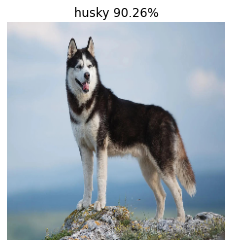

In [25]:
plot_predict(ToTensor('./custom_images/Siberian-Husky-dog.jpg'))

In [31]:
images_path = [os.path.join(custom_images_dir, image_name) for image_name in os.listdir(custom_images_dir)]
for image in images_path :
    ToJPG(image) 

In [36]:
images_path = [os.path.join(custom_images_dir, image_name) for image_name in os.listdir(custom_images_dir)]
images_path

['./custom_images/Siberian-Husky-dog.jpg',
 './custom_images/Shiba-Inu-2.jpg',
 './custom_images/pretty-bombay-cat.jpg',
 './custom_images/Shiba-Inu-standing-in-profile-outdoors.jpg']

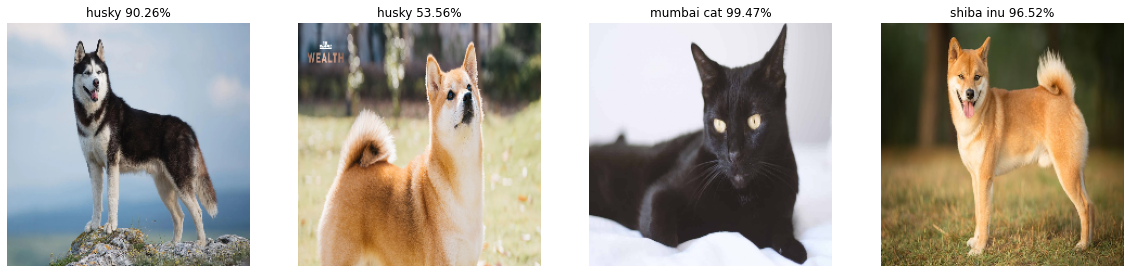

In [38]:
plt.figure(figsize=(20, 9))
for i, image in enumerate(images_path, start=1) :
    imageTensor = ToTensor(image)
    plt.subplot(1, 4, i)
    plot_predict(imageTensor)